# Variational Message Passing for Estimation

ForneyLab comes with support for variational message passing (VMP) (Dauwels, 2007):

- Dauwels J., On variational message passing on factor graphs, IEEE Intl symposium on information theory, Nice (France), June 2007

In this demo we illustrate VMP by estimating the mean and precision (inverse variance) of a Gaussian distribution from samples. The model is defined as:

\begin{align*}
    m   &\sim \mathcal{N}(0, 100)\\
    w   &\sim \mathcal{G}am(0.01, 0.01)\\
    y_i &\sim \mathcal{N}(m, w^{-1}) \,\,\text{for}\,\, i=1,\ldots,n
\end{align*}

Variational inference approximates the posterior over $m$ and $w$ by a recognition distribution. We minimize the KL divergence between the recognition distribution and the exact posterior through variational message passing.

Let's first generate a data set

In [1]:
# Generate toy data set
n = 5

m_data = 3.0
w_data = 4.0
y_data = sqrt(1/w_data)*randn(n) .+ m_data;

# Model specification

In [2]:
using(ForneyLab)

g = FactorGraph()

# Priors
@RV m ~ GaussianMeanVariance(0.0, 100.0)
@RV w ~ Gamma(0.01, 0.01)

# Observarion model
y = Vector{Variable}(undef, n)
for i = 1:n
    @RV y[i] ~ GaussianMeanPrecision(m, w)
    placeholder(y[i], :y, index=i)
end

# Algorithm generation

With the model defined, we can now specify a **factorized recognition distribution**

$$\begin{align*}
    q(m, w) = q(m)\times q(w)
\end{align*}$$

through the `RecognitionFactorization()` constructor. All variables that are deterministically linked to the argument variables (e.g. through a `+` or `=` relation) automatically become part of a single recognition factor. We can also inspect the subgraph corresponding to a recognition factor with the `ForneyLab.draw()` function.

In [3]:
# Specify recognition factorization
q = RecognitionFactorization(m, w, ids=[:M, :W])

# Inspect the subgraph for m
ForneyLab.draw(q.recognition_factors[:M])

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8042282516275311480 -->
 8042282516275311480 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 2090025442683569238 -->
 2090025442683569238 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 17384827021452721483 -->
 17384827021452721483 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 3226700531779314931 -->
 3226700531779314931 
 
<!-- 17384827021452721483--3226700531779314931 -->
 17384827021452721483--3226700531779314931 
 
 1 out 
 2 m 
 
<!-- 14013305188951692355 -->
 14013305188951692355 
 
<!-- 17384827021452721483--14013305188951692355 -->
 17384827021452721483--14013305188951692355 
 
 1 out 
 3 v 
 
<!-- 17360469982711753225 -->
 17360469982711753225 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1579565682335134641 -->
 1579565682335134641 
 
 = 
 equ_m_1 
 
<!-- 1579565682335134641--17384827021452721483 -->
 1579565682335134641--17384827021452721483 
 
 m 
 1 out 
 1 1 
 
<!-- 1579565682335134641--17360469982711753225 -->
 1579565682335134641--17360469982711753225 
 
 m 
 2 m 
 2 2 
 
<!-- 13789062747283106191 -->
 13789062747283106191 
 
 = 
 equ_m_2 
 
<!-- 13789062747283106191--2090025442683569238 -->
 13789062747283106191--2090025442683569238 
 
 m 
 2 m 
 1 1 
 
<!-- 13789062747283106191--1579565682335134641 -->
 13789062747283106191--1579565682335134641 
 
 m 
 3 3 
 2 2 
 
<!-- 3425679821146906255 -->
 3425679821146906255 
 
 = 
 equ_m_4 
 
<!-- 14785741588461913559 -->
 14785741588461913559 
 
 = 
 equ_m_3 
 
<!-- 3425679821146906255--14785741588461913559 -->
 3425679821146906255--14785741588461913559 
 
 m 
 3 3 
 2 2 
 
<!-- 16462784247255146282 -->
 16462784247255146282 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 3425679821146906255--16462784247255146282 -->
 3425679821146906255--16462784247255146282 
 
 m 
 2 m 
 1 1 
 
<!-- 12973867171606378946 -->
 12973867171606378946 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 3425679821146906255--12973867171606378946 -->
 3425679821146906255--12973867171606378946 
 
 m 
 2 m 
 3 3 
 
<!-- 14785741588461913559--8042282516275311480 -->
 14785741588461913559--8042282516275311480 
 
 m 
 2 m 
 1 1 
 
<!-- 14785741588461913559--13789062747283106191 -->
 14785741588461913559--13789062747283106191 
 
 m 
 3 3 
 2 2 
 
<!-- 1625482612921750138 -->
 1625482612921750138 
 
<!-- 1625482612921750138--2090025442683569238 -->
 1625482612921750138--2090025442683569238 
 
 3 w 
 1 1 
 
<!-- 6439326280335639132 -->
 6439326280335639132 
 
<!-- 6439326280335639132--8042282516275311480 -->
 6439326280335639132--8042282516275311480 
 
 1 out 
 1 out 
 
<!-- 9417069308240232139 -->
 9417069308240232139 
 
<!-- 9417069308240232139--12973867171606378946 -->
 9417069308240232139--12973867171606378946 
 
 1 out 
 1 out 
 
<!-- 1836631816699938256 -->
 1836631816699938256 
 
<!-- 1836631816699938256--16462784247255146282 -->
 1836631816699938256--16462784247255146282 
 
 3 w 
 1 1 
 
<!-- 1836631816699938256--12973867171606378946 -->
 1836631816699938256--12973867171606378946 
 
 3 w 
 3 3 
 
<!-- 7602537700295351875 -->
 7602537700295351875 
 
<!-- 7602537700295351875--8042282516275311480 -->
 7602537700295351875--8042282516275311480 
 
 3 w 
 1 1 
 
<!-- 1128424821311894335 -->
 1128424821311894335 
 
<!-- 1128424821311894335--17360469982711753225 -->
 1128424821311894335--17360469982711753225 
 
 3 w 
 2 2 
 
<!-- 10254751795090054212 -->
 10254751795090054212 
 
<!-- 10254751795090054212--2090025442683569238 -->
 10254751795090054212--2090025442683569238 
 
 1 out 
 1 out 
 
<!-- 129053967691354421 -->
 129053967691354421 
 
<!-- 129053967691354421--1646278

In [4]:
# Inspect the subgraph for W
ForneyLab.draw(q.recognition_factors[:W])

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 2979836484394216385 -->
 2979836484394216385 
 
 Gam 
 gamma_1 
 
<!-- 9720539321468345172 -->
 9720539321468345172 
 
<!-- 2979836484394216385--9720539321468345172 -->
 2979836484394216385--9720539321468345172 
 
 1 out 
 2 a 
 
<!-- 17417645835071101442 -->
 17417645835071101442 
 
<!-- 2979836484394216385--17417645835071101442 -->
 2979836484394216385--17417645835071101442 
 
 1 out 
 3 b 
 
<!-- 2090025442683569238 -->
 2090025442683569238 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 17360469982711753225 -->
 17360469982711753225 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 1128424821311894335 -->
 1128424821311894335 
 
 = 
 equ_w_1 
 
<!-- 1128424821311894335--2979836484394216385 -->
 1128424821311894335--2979836484394216385 
 
 w 
 1 out 
 1 1 
 
<!-- 1128424821311894335--17360469982711753225 -->
 1128424821311894335--17360469982711753225 
 
 w 
 3 w 
 2 2 
 
<!-- 7602537700295351875 -->
 7602537700295351875 
 
 = 
 equ_w_3 
 
<!-- 1625482612921750138 -->
 1625482612921750138 
 
 = 
 equ_w_2 
 
<!-- 7602537700295351875--1625482612921750138 -->
 7602537700295351875--1625482612921750138 
 
 w 
 3 3 
 2 2 
 
<!-- 8042282516275311480 -->
 8042282516275311480 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 7602537700295351875--8042282516275311480 -->
 7602537700295351875--8042282516275311480 
 
 w 
 3 w 
 1 1 
 
<!-- 16462784247255146282 -->
 16462784247255146282 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 1625482612921750138--2090025442683569238 -->
 1625482612921750138--2090025442683569238 
 
 w 
 3 w 
 1 1 
 
<!-- 1625482612921750138--1128424821311894335 -->
 1625482612921750138--1128424821311894335 
 
 w 
 3 3 
 2 2 
 
<!-- 1836631816699938256 -->
 1836631816699938256 
 
 = 
 equ_w_4 
 
<!-- 1836631816699938256--7602537700295351875 -->
 1836631816699938256--7602537700295351875 
 
 w 
 3 3 
 2 2 
 
<!-- 1836631816699938256--16462784247255146282 -->
 1836631816699938256--16462784247255146282 
 
 w 
 3 w 
 1 1 
 
<!-- 12973867171606378946 -->
 12973867171606378946 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 1836631816699938256--12973867171606378946 -->
 1836631816699938256--12973867171606378946 
 
 w 
 3 w 
 3 3 
 
<!-- 13789062747283106191 -->
 13789062747283106191 
 
<!-- 13789062747283106191--2090025442683569238 -->
 13789062747283106191--2090025442683569238 
 
 2 m 
 1 1 
 
<!-- 6439326280335639132 -->
 6439326280335639132 
 
<!-- 6439326280335639132--8042282516275311480 -->
 6439326280335639132--8042282516275311480 
 
 1 out 
 1 out 
 
<!-- 1579565682335134641 -->
 1579565682335134641 
 
<!-- 1579565682335134641--17360469982711753225 -->
 1579565682335134641--17360469982711753225 
 
 2 m 
 2 2 
 
<!-- 3425679821146906255 -->
 3425679821146906255 
 
<!-- 3425679821146906255--16462784247255146282 -->
 3425679821146906255--16462784247255146282 
 
 2 m 
 1 1 
 
<!-- 3425679821146906255--12973867171606378946 -->
 3425679821146906255--12973867171606378946 
 
 2 m 
 3 3 
 
<!-- 9417069308240232139 -->
 9417069308240232139 
 
<!-- 9417069308240232139--12973867171606378946 -->
 9417069308240232139--12973867171606378946 
 
 1 out 
 1 out 
 
<!-- 14785741588461913559 -->
 14785741588461913559 
 
<!-- 14785741588461913559--8042282516275311480 -->
 14785741588461913559--8042282516275311480 
 
 2 m 
 1 1 
 
<!-- 10254751795090054212 -->
 10254751795090054212 
 
<!-- 10254751795090054212--2090025442683569238 -->
 10254751795090054212--2090025442683569238 
 
 1 out 
 1 out 
 
<!-- 129053967691354421 -->
 129053967691354421 
 
<!-- 129053967691354421--16462784247255146282 -->
 129053967

In [5]:
# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# And inspect the algorithm code
println(algo)

begin

function stepM!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 10))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=0.0), ProbabilityDistribution(Univariate, PointMass, m=100.0))
messages[2] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][4]), nothing, marginals[:w])
messages[3] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][5]), nothing, marginals[:w])
messages[4] = ruleSPEqualityGaussian(messages[2], nothing, messages[3])
messages[5] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][3]), nothing, marginals[:w])
messages[6] = ruleSPEqualityGaussian(messages[5], nothing, messages[4])
messages[7] = ruleVBGaussianMeanPrecisionM(ProbabilityDistribution(Univariate, PointMass, m=data[:y][2]), nothing, marginals[:w])
messages[8] = ruleSPEqualityGaussian(messages[7], nothing,

Note that the algorithm now contains two `step!()` functions: one for each recognition factor. This is because variational message passing is an iterative algorithm, where `stepM!()` requires the marginal from `marginals[:w]` and `stepW!()` requires `marginals[:m]`. This requires us to initialize the marginals before we start the inference. The `marginals` argument allows us to pass an initial dictionary of marginals. Upon execution, this dictionary is updated in-place with the newly computed outcomes.

Additionally, we can also automatically generate code that evaluates the free energy, with `freeEnergyAlgorithm()`. This yields a model-specific `freeEnergy()` function that accepts the `data` and `marginals` dictionaries. 

The free energy can be used to check for convergence or to perform model comparisons.

In [6]:
algo_F = freeEnergyAlgorithm(q)

println(algo_F)

function freeEnergy(data::Dict, marginals::Dict)

F = 0.0

F += averageEnergy(Gamma, marginals[:w], ProbabilityDistribution(Univariate, PointMass, m=0.01), ProbabilityDistribution(Univariate, PointMass, m=0.01))
F += averageEnergy(GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][1]), marginals[:m], marginals[:w])
F += averageEnergy(GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][2]), marginals[:m], marginals[:w])
F += averageEnergy(GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][3]), marginals[:m], marginals[:w])
F += averageEnergy(GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][4]), marginals[:m], marginals[:w])
F += averageEnergy(GaussianMeanPrecision, ProbabilityDistribution(Univariate, PointMass, m=data[:y][5]), marginals[:m], marginals[:w])
F += averageEnergy(GaussianMeanVariance, marginals[:m], ProbabilityDistribution(Univariate, PointMass, m=0.0), Pr

# Execution

In [7]:
# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F));

As mentioned before, we need to initialize the `marginals` dictionary. After initialization, we iteratively step through the algorithm functions and evaluate the free energy and estimates after each iteration (for visualization purposes).

In [8]:
data = Dict(:y => y_data)

# Initial recognition distributions
marginals = Dict(:m => vague(GaussianMeanVariance),
                 :w => vague(Gamma))

n_its = 2*n
F = Vector{Float64}(undef, n_its) # Initialize vector for storing Free energy
m_est = Vector{Float64}(undef, n_its)
w_est = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepM!(data, marginals)
    stepW!(data, marginals)
    
    # Store free energy
    F[i] = freeEnergy(data, marginals)
    
    # Store intermediate estimates
    m_est[i] = mean(marginals[:m])
    w_est[i] = mean(marginals[:w])
end
;

# Results
Below we solve the same problem using exact inference and compare it with our approximated solution.

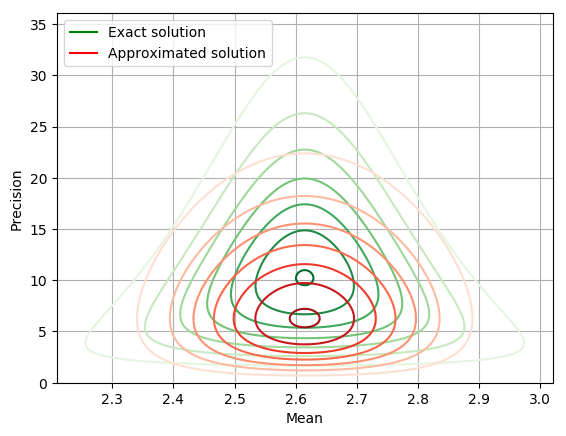

In [9]:
using PyPlot, PyCall ; 
@pyimport matplotlib.lines as mlines

# Calculate posterior distribution using exact inference
𝓝(x, μ, σ²) = (1/(sqrt(2π*σ²))) * exp.(-(x .- μ).^2 / (2*σ²))
Gam(λ, a, b) = (1/factorial(a-1)) * b^a * λ.^(a-1) .* exp.(-b*λ)
like(D, rμ, rτ) = [(τ/(2*pi))^(length(D)/2) * exp(-(τ/2)*sum((D .- μ).^2)) for μ=rμ, τ=rτ]
prior(rμ, rτ, μ₀, λ₀, a₀, b₀) = [𝓝(μ, μ₀, (λ₀*τ)^(-1)) * Gam(τ, a₀, b₀) for μ=rμ, τ=rτ ]
post(rμ, rτ, D, μ₀, λ₀, a₀, b₀) = [like(D, μ, τ) .* prior(μ, τ, μ₀, λ₀, a₀, b₀) for μ=rμ, τ=rτ ]

# Plot both the exact and approximated solutions
std_dev_ml = sqrt(var(y_data)/length(y_data))
rμ = range(mean(y_data)-3*std_dev_ml, mean(y_data)+3*std_dev_ml, length=1000)
rτ = range(0, 3.3(1/var(y_data)), length=1000)

contour([μ for μ=rμ, τ=rτ], [τ for μ=rμ, τ=rτ], post(rμ, rτ, y_data, 0, 0.001, 0.01, 0.01), cmap="Greens")

approx(rμ, rτ, m_μ, v_μ, a_ω, b_ω) = [𝓝(μ, m_μ, v_μ) * Gam(τ, a_ω, b_ω) for μ=rμ, τ=rτ ]

contour([μ for μ=rμ, τ=rτ], [τ for μ=rμ, τ=rτ], 
    approx(rμ, rτ, mean(marginals[:m]), var(marginals[:m]), marginals[:w].params[:a], marginals[:w].params[:b]),
    cmap="Reds")

green_patch = mlines.Line2D([], [], color="green", label="Exact solution")
red_patch = mlines.Line2D([], [], color="red", label="Approximated solution")
legend(handles=[green_patch, red_patch], loc="upper left")
xlabel("Mean"); ylabel("Precision"); grid(true);

The plot below shows the convergence of the free energy.

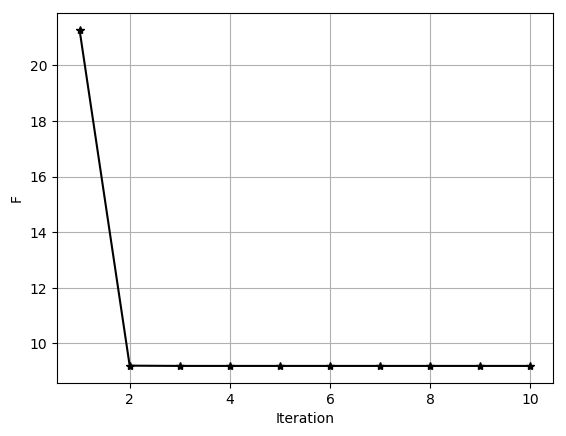

In [10]:
using PyPlot

# Plot free energy to check for convergence
plot(1:n_its, F, color="black", marker="*")
grid(true); xlabel("Iteration"); ylabel("F");